In [2]:
import random
import shutil
import pathlib
import os, glob
import itertools
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from arcface import ArcFace
from mtcnn.mtcnn import MTCNN
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from sklearn.utils import class_weight 
from sklearn.ensemble import RandomForestClassifier
from transformers import AutoTokenizer, AutoModelWithLMHead
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

c:\Users\Legion\.conda\envs\tf210\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Legion\.conda\envs\tf210\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Legion\.conda\envs\tf210\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Face Emotion

In [3]:
def extract_face(
				frame,
				detector = MTCNN(), 
				required_size=(512, 512)
				):
	results = detector.detect_faces(frame)
	x1, y1, width, height = results[0]['box']

	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	face = frame[y1:y2, x1:x2]

	face = Image.fromarray(face)
	face = face.resize(required_size)
	face = np.asarray(face)
	return face

In [4]:
train_data_path = 'data/train'
test_data_path = 'data/test'

train_embeddings_path = 'feature_store/train_embeddings.npz'
test_embeddings_path = 'feature_store/test_embeddings.npz'

width = 150
height = 150
target_size = (width, height)
input_shape = (width, height, 3)

face_rec = ArcFace.ArcFace()
encoding_dim = 512

class_dict = {
            'anger': 0,
            'disgust': 1,
            'fear': 2,
            'happy': 3,
            'sadness': 4,
            'surprise': 5
            }

In [5]:
def encode_dataset(
                  data_path,
                  embeddings_path
                  ):
    if not os.path.exists(embeddings_path):
        all_images = glob.glob(data_path + '/*/*.*')
        all_images = [x.replace('\\', '/') for x in all_images]

        all_labels = [x.split('/')[-2] for x in all_images]
        labels = [class_dict[x] for x in all_labels]
        images = [cv.cvtColor(cv.imread(x), cv.COLOR_BGR2RGB) for x in all_images]

        print("Images are loaded, Embedding Generating for {} set".format(data_path.split('/')[-1]))
        encodings = face_rec.calc_emb(images)
        np.savez_compressed(
                            embeddings_path, 
                            encodings=encodings,
                            labels=labels
                            )
        
    else:
        data = np.load(embeddings_path)
        encodings = data['encodings']
        labels = data['labels']

    return encodings, labels

In [6]:
train_encodings, train_labels = encode_dataset(train_data_path, train_embeddings_path)
test_encodings, test_labels = encode_dataset(test_data_path, test_embeddings_path)

In [6]:
RFC = RandomForestClassifier(
                            n_estimators=100,
                            max_depth=10,
                            random_state=42
                            )

RFC.fit(train_encodings, train_labels)

RandomForestClassifier(max_depth=10, random_state=42)

In [8]:
# accuracy score 
train_pred = RFC.predict(train_encodings)
test_pred = RFC.predict(test_encodings)

acc_train = accuracy_score(train_labels, train_pred)
acc_test = accuracy_score(test_labels, test_pred)

print("Train Accuracy: {:.2f}%".format(acc_train*100))
print("Test Accuracy: {:.2f}%".format(acc_test*100))

Train Accuracy: 97.87%
Test Accuracy: 98.33%


In [9]:
# classification report

print("Train Classification Report")
print(classification_report(train_labels, train_pred))

print("Test Classification Report")
print(classification_report(test_labels, test_pred))

Train Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1500
           1       0.94      0.99      0.97      1500
           2       0.99      0.98      0.99      1500
           3       0.98      0.98      0.98      1500
           4       0.99      0.98      0.99      1500
           5       0.99      0.96      0.97      1500

    accuracy                           0.98      9000
   macro avg       0.98      0.98      0.98      9000
weighted avg       0.98      0.98      0.98      9000

Test Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       300
           1       0.95      1.00      0.97       300
           2       0.99      0.98      0.99       300
           3       0.99      0.98      0.98       300
           4       1.00      0.99      0.99       300
           5       0.98      0.97      0.97       300

    accuracy          

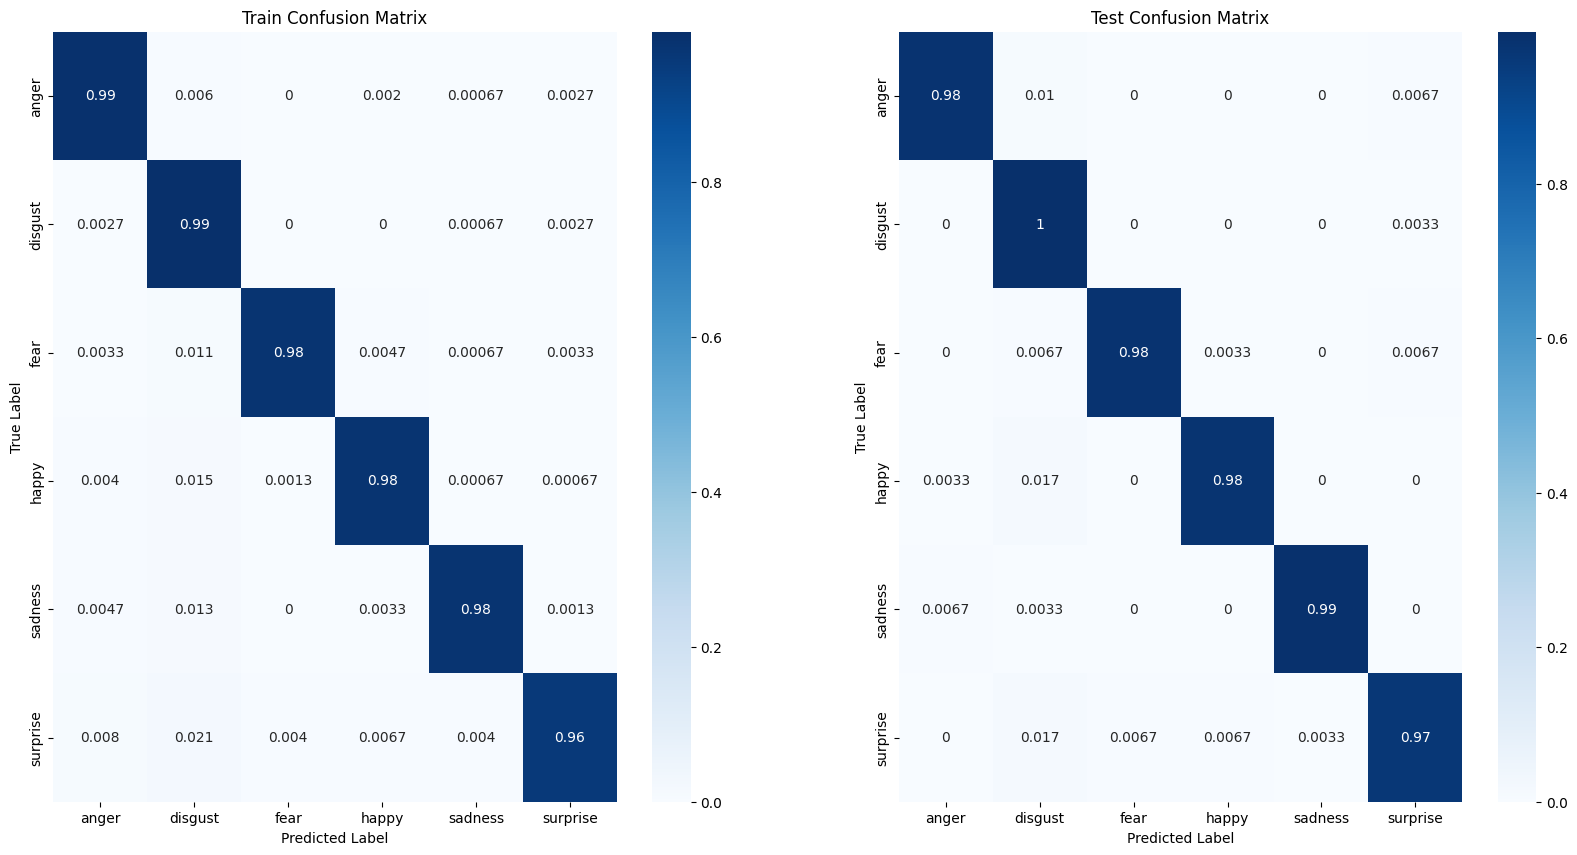

In [15]:
# confusion matrix
cm_train = confusion_matrix(train_labels, train_pred)
cm_test = confusion_matrix(test_labels, test_pred)
class_names = list(class_dict.keys())

# normalize confusion matrix
cm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

# plot confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(
            cm_train,
            annot=True,
            cmap=plt.cm.Blues,
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax1
            )
ax1.set_title("Train Confusion Matrix")
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

sns.heatmap(
            cm_test,
            annot=True,
            cmap=plt.cm.Blues,
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax2
            )
ax2.set_title("Test Confusion Matrix")
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')
plt.show()

# Text Emotion

In [10]:
tokenizer_text_emotion = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model_text_emotion = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

def get_emotion(text):
    input_ids = tokenizer_text_emotion.encode(text + '</s>', return_tensors='pt')

    output = model_text_emotion.generate(
                                        input_ids=input_ids,
                                        max_length=2
                                        )
    
    dec = [tokenizer_text_emotion.decode(ids) for ids in output]
    label = dec[0]
    label = label.split()[-1]

    if label in ['joy', 'love']:
        label = 'happy'
    return label

c:\Users\Legion\.conda\envs\tf210\lib\site-packages\transformers\models\auto\modeling_auto.py:1352: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


# Inference

In [7]:
import pathlib
import cv2 as cv
from mtcnn.mtcnn import MTCNN
from fastai.vision.all import *

temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

model_face_emotion = load_learner('feature_store/face_emotions.pkl')
face_emotion_labels = model_face_emotion.dls.vocab

tokenizer_text_emotion = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model_text_emotion = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

emotion_arr = [
                'angry',
                'disgust',
                'fear',
                'happy',
                'neutral',
                'sad',
                'surprise'
                ]

c:\Users\Legion\.conda\envs\tf210\lib\site-packages\transformers\models\auto\modeling_auto.py:1352: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [12]:
def face_emotion_inference(
                            video_path,
                            multiplier=10
                            ):
    cap = cv.VideoCapture(video_path)
    multiplier = int(cap.get(cv.CAP_PROP_FPS)) * 4
    print("FRAME RATE: ", multiplier)
    
    frames = []
    counter = 0
    while True:
        ret, frame = cap.read()
        print(frame)
        if not ret:
            break
        if counter % multiplier == 0:
            try:
                frame = extract_face(frame, required_size=(48, 48))
                frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
                frame = PILImage.create(frame)
                frames.append(frame)
            except:
                pass
        counter += 1
    cap.release()

    probs_emotion = [model_face_emotion.predict(x) for x in frames]
    emotions = [x[0] for x in probs_emotion]
    probabilities = [float(x[2][x[1]]) for x in probs_emotion]

    df = pd.DataFrame({
                        'emotion': emotions,
                        'probability': probabilities
                        })
    df = df[df['probability'] > 0.9]
    emotion_count = df['emotion'].value_counts(normalize=True)
    return emotion_count.index[0]

def text_emotion_inference(text):
    input_ids = tokenizer_text_emotion.encode(text + '</s>', return_tensors='pt')

    output = model_text_emotion.generate(
                                        input_ids=input_ids,
                                        max_length=2
                                        )
    
    dec = [tokenizer_text_emotion.decode(ids) for ids in output]
    label = dec[0]
    label = label.split()[-1]

    if label in ['joy', 'love']:
        label = 'happy'
    return label

In [13]:
face_emotion_inference('uploads/sample.avi')

FRAME RATE:  4
[[[204 212 209]
  [204 212 209]
  [204 212 209]
  ...
  [190 196 191]
  [191 197 192]
  [191 197 192]]

 [[206 214 211]
  [206 214 211]
  [206 214 211]
  ...
  [190 196 191]
  [190 196 191]
  [190 196 191]]

 [[206 214 211]
  [206 214 211]
  [206 214 211]
  ...
  [189 195 190]
  [189 195 190]
  [189 195 190]]

 ...

 [[193 203 207]
  [192 202 206]
  [191 201 205]
  ...
  [ 58 108 155]
  [ 58 108 155]
  [ 58 108 155]]

 [[195 205 209]
  [193 203 207]
  [192 202 206]
  ...
  [ 57 107 154]
  [ 58 108 155]
  [ 58 108 155]]

 [[192 202 206]
  [193 203 207]
  [195 205 209]
  ...
  [ 58 108 155]
  [ 58 108 155]
  [ 57 107 154]]]
[[[172 189 193]
  [172 189 193]
  [172 189 193]
  ...
  [181 196 194]
  [181 196 194]
  [181 196 194]]

 [[171 188 192]
  [171 188 192]
  [171 188 192]
  ...
  [181 196 194]
  [181 196 194]
  [181 196 194]]

 [[171 188 192]
  [171 188 192]
  [171 188 192]
  ...
  [181 196 194]
  [181 196 194]
  [181 196 194]]

 ...

 [[118 140 155]
  [118 140 155]
  [11

IndexError: index 0 is out of bounds for axis 0 with size 0